In a previous notebook, we have shown how to [fit a psychometric curve using pyTorch](https://laurentperrinet.github.io/sciblog/posts/2020-04-08-fitting-a-psychometric-curve-using-pytorch.html). Here, I would like to review some nice properies of the logistic regression model (WORK IN PROGRESS). 

<!-- TEASER_END -->

Let's first initialize the notebook:

# quelques définitions

## initialisation du notebook

Nous allons importer quelques librairies qui seront utilisées pour la manipulation numérique de matrices et l'affichage:

In [1]:
import time
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
fig_width = 10
phi = np.sqrt(5)/2 + 1/2
figsize = (fig_width, fig_width/phi)

## Définition des variables et fonctions

... utiles pour réaliser une classification  de données synthétiques selon une régression logistique

On va utiliser des données organisés suivant des échantillons (de taille `N_batch`) pour lesquels on va avoir la relation suivante pour calculer le vecteur de sortie $Y$ de taille $K$ en fonction du vecteur d'entrée $X$ de taille $N$ :

$$
Y \approx \mathcal{B}( \sigma( \bar{X} \bar{W}^T ) )  
$$

où:
* $\mathcal{B}(p)$ représente un tirage de Bernoulli et $\approx$ représente que c'est un tirage de cette loi avec le paramètre $p$,
* $\sigma$ est la fonction sigmiode,
* $\bar{X}$ est le vectuer $X$ auquel on a rajouté un $1$ pour calculer le biais (sur la dernière ligne),
* $\bar{W}$ est la matrice de poids augmentée des biais (sur la dernière ligne) et donc de taille $K+1 \times (N+1)$.


In [2]:
N = 256 # nombre de valeurs de l'entrée
n_classes = 10 # nombre de classes
N_batch = 347 # nombre d'échantillons
seed = 1973

np.random.seed(seed)
W_scale = 1.
W = W_scale * np.random.randn(n_classes, N+1) # FIXED design matrix of weights (w) according to classes

# Definition de l'évidence (e) 
def evidence(W, X):
    """
    Modèle génératif de l'évidence:
    W[:-1, :] = N poids pour n_classes
    W[-1, :] = 1 biais pour chaque classe
    """
    e = (X @ W[:, :-1].T) + W[:, -1] 
    return e

# Transformation de l'entrée (e) en probabilité (p) selon une courbe de regression logistique
def sigmoid(logodds):
    return 1 / (1 + np.exp(-logodds))

def get_data(W, seed, N_batch, X_scale = .5, X_type='normal'):
    N, n_classes = W.shape[1]-1, W.shape[0]
    np.random.seed(seed)
    # nos entrées (X) : n_batch échantillons comprenant chacun N valeurs
    # tirage de causes aléatoires
    if X_type=='normal':
        X = X_scale * np.random.randn(N_batch, N)
    elif  X_type=='poisson':
        X = X_scale * np.random.poisson(size=(N_batch, N))
    else: # 'binary'
        X = X_scale > np.random.rand(N_batch, N)
        
    # modèle génératif: mélange
    p = sigmoid(evidence(W, X))
    # Tirage de Bernoulli : si p > à random => 1, si p < à random = 0 
    y = p > np.random.rand(N_batch, n_classes) # Bernoulli, generate data 
    
    return X, p, y

In [3]:
X, p, y = get_data(W, seed, N_batch)
e = evidence(W, X)

In [4]:
X, p, y = get_data(W, seed, N_batch) 
X.shape, e.shape, p.shape, y.shape

((347, 256), (347, 10), (347, 10), (347, 10))

Avec _`X, p, y = get_data(W, seed, N_batch)`_ on appelle la fct get_data, qui appelle la fonction `sigmoid`, qui appelle la fonction evidence afin de nous renvoyer les entrées X (100 entrées, comprenant chacune 256 valeures), les probabilités de classification de ces différentes entrées dans les différentes classes (p), et la classification après tirage de bernoulli (y = succès si p > 0.5, echcec si p < 0.5). Pour visualiser les sorties (p et y) en fonction des entrées (X et e), on les stock dans des arrays. 

## Visualisation des données

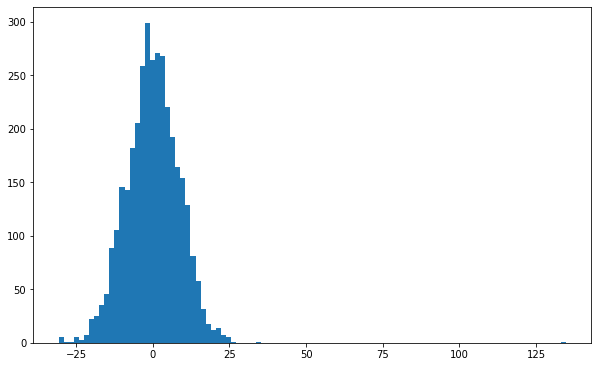

In [5]:
fig, ax = plt.subplots(figsize=figsize)
counts, bins, _ = ax.hist(e.ravel(), bins=100) 

Visualisation de p en fonction de e pour une classe :

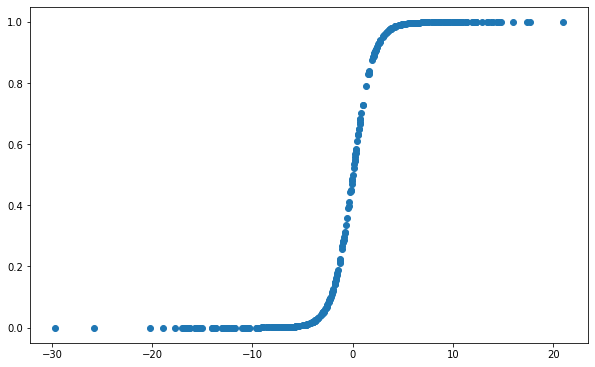

In [6]:
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(e[:,1], p[:,1]) 

Visualisation de p en fonction de e pour une classe + de la sortie (tirage de Bernoulli = y) 

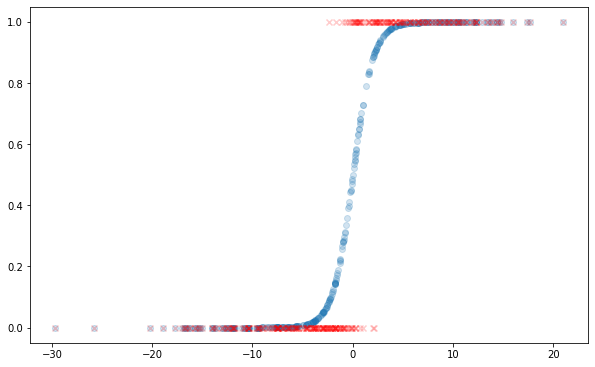

In [7]:
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(e[:,1],p[:,1], alpha=.2) #proba de e d'être classifié dans classe 1
ax.scatter(e[:,1],y[:,1], alpha=.2, marker="x", color="red") #Sortie de Bernoulli 

Visualisation de la distribution des probabilités de classification 

(array([1353.,  153.,   86.,   70.,   47.,   64.,   81.,   83.,  139.,
        1394.]),
 array([4.71559811e-14, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

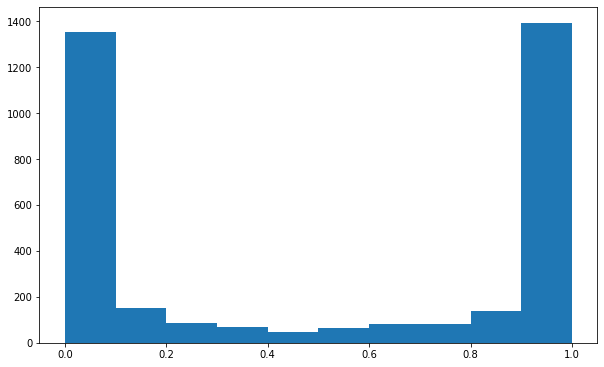

In [8]:
fig, ax = plt.subplots(figsize=figsize)
ax.hist(p.ravel(), bins=10)

Distribution qui se rapproche d'une beta distribution.

Visualisation de p en fonction de chaque entrée X + de la sortie y  'permise' par l'ajout des w et biais 

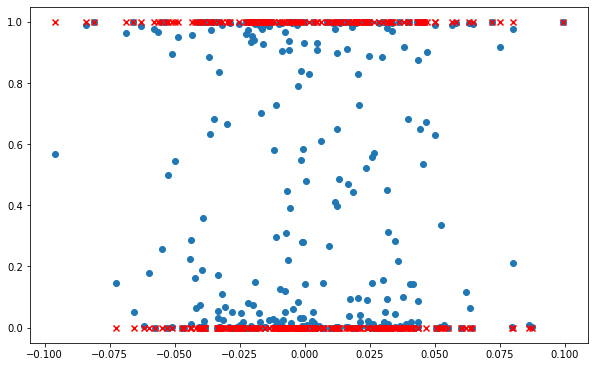

In [9]:
X_1 = np.average(X.reshape(-1, 256), axis=1)
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(X_1,p[:,1]) 
ax.scatter(X_1,y[:,1],marker="x", color="red")

... la situation est plus confuse... est-ce quon va arriver à distinguer les différents cas?

# Inversion par apprentissage supervisé

## Définition du réseau d'inversion

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size//the sum of the output will be divided by the number of elements in the output
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output 

class LogisticRegressionModel(torch.nn.Module):
    
    # voir ce que signifie self 
    # voir ce que signifie super 
    
    def __init__(self, N, n_classes, bias=True): # (self, input_dim, output_dim)
        super(LogisticRegressionModel, self).__init__() 
        
        # 1ere couche : self.linear = torch.nn.Linear(input_dim, output_dim, bias=true) bias = true pour apprentissage
        self.linear = torch.nn.Linear(N, n_classes, bias=bias) 
        
        # 2e couche : self.nl = torch.nn.Sigmoid() = ouputs 
        # autre possibilité : self.nl = torch.nn.LogSoftmax(n_classes)
        self.nl = torch.nn.Sigmoid()
    
    # maintenant qu'on a définit les couches, on peut les utiliser dans la classe:
    # - self.linear me donne l'accumulation d'évidence,
    # - self.nl me donne la sigmoïde de e 
    
    def forward(self, X):
        # X = (N, n_batch) là on est dans 1 batch donc X = 256 = N 
        return self.nl(self.linear(X))

 __init__ permet de définir notre NN, les couches, leur role, la dimention des entrées et sorties
 
On a un réseau composé de deux couches : 
- la première (self.linear) réalise une transformation linéaire de nos entrées X (de dimention N =  256) de sorte à ce que la sortie y = (w*x)+biais = e (de dimention n_classes = 10). Une entrée sera associée aux différentes classes avec un w et un biais associé pour chacune des classes. Après plusieurs batch, on obtiendra plusieurs e pour la même ent alors plusieurs e pour chaque classes.
    
- la deuxième (self.nl) transforme ces sorties (e) pour leur donner une distribution sigmoïde. On obtient ainsi la probabilité de classification de l'entrée X, associée à un poid w et au biais. On aura n_classes sigmoïdes, représentant la probabilité de classification de l'entrée dans chacune des classes en fonction du w et du biais associé. 

La fonction __forward__ permet de construire le réseau en connectant les couches selon un modèle forward : self.nl(self.linear(X))

Par la suite, le réseau va modifier ses paramètres : w et biais de sorte à ce que la classification des X se fasse de la même manière que pendant l'initialisation

-> Pour cela, on demande à notre réseau de calculer la loss function entre la classification réalisée par self.nl(self.linear(X)) et celle réalisée par y 

-> Plus la différence est grande, plus la loss function l'est aussi et plus le réseau va modifier ses paramètres (W et biais) pour classifier de la même façon que pdt l'initialisation 

-> On devrait donc retrouver à la fin des W et des biais similaires entre ceux fixés par nous pendant l'initialisation et ceux déterminés par le réseau pdt l'inversion 


In [11]:
logistic_model = LogisticRegressionModel(N, n_classes) #(input_dim, output_dim)

In [12]:
bias_before_training = logistic_model.linear.bias
w_before_training = logistic_model.linear.weight
#bias_before_training.shape # shape = 10 car 1 biais associé à une classe, pour tous les x 
#w_before_training.shape # shape =  ([10, 256]) car pour chaque classe, on attribue 1 poid à chaque X

## Définition des variables d'apprentissage, d'entrée et de sortie

In [13]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1 # epoch = le nombre de passages dans l'ensemble des données d'entraînement que le réseau a effectués, ici 513 max
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

batch_size = 100
n_classes= 10

X = torch.randn(N_batch, N)
outputs = logistic_model(X)


## Défition des fonctions pour l'apprentissage des w et biais pour classification

In [14]:
def fit_data(X, y, learning_rate=learning_rate,batch_size=batch_size,num_epochs=num_epochs,betas=betas,verbose=False, **kwargs):

    X_0 = torch.Tensor(X[:, None]) # rajoute une dimention de taille 1 : pk ? 
    labels = torch.Tensor(y[:, None]) # remplace les True/False par des 1 et 0, rajoute une dimention de taille 1 : pk ? 
    
    loader = DataLoader(TensorDataset(X_0, labels), batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_batch = X.shape[0] # = 100
    N = X.shape[1] # = 256 
    n_classes = y.shape[1] # = 10
    
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad) # diminue le learning rate petit à petit de sorte à atteindre le minimum de la loss function / Adam utilise une moyenne à décroissance exponentielle des gradients passés afin de fournir une fréquence d'apprentissage adaptative. 
    
    for epoch in range(int(num_epochs)): # on commence à 1 jusq'à 513 epoch, cad qu'il passe par tous les X_ 513 fois
        logistic_model.train()
        losses = [] 
        for X_, labels_ in loader: 
            X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X_)  
            loss = criterion(outputs, labels_) #calcul de la différence entre l'outpul de logistic_model et la classification effectuée pdt l'initialisation (PROBLEME ? on compare des proba à y=true/false)
                                               
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()         
            
            losses.append(loss.item())   

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}") 

    logistic_model.eval()
    X_0, labels = torch.Tensor(X[:, None]), torch.Tensor(y[:, None]) #utile ? 
    outputs = logistic_model(X_0) #utile ? 
    loss = criterion(outputs, labels).item()
    return logistic_model, loss

Dans la fonction __fit_data__ :
- On commence par __définir les variables d'intéret et l'optimizer__. Lors de la définition de l'optimizer, on lui indique __quel paramètre il doit modfier__ pendant l'apprentissage et le learning rate. Ici les paramètres modifiés par l'optimizer sont les poids et biais associés aux entrées pour les différentes classes. L'optimizer Adam va modifier le poid et le biais des différentes classes pour que la classfication des entrées soit similaire à celle obtenue pendant l'initialisation. Pour cela, il fait ........... . La particularité de cet optimizer est qu'il diminue le learning rate en même temps que la différence diminue. Le learning rate correspond au nombre de pas necessaire pour atteindre le minimum de loss function- à approfondir - 

- En suite, __on commence l'entrainement__ à partir des données comprises dans loader (= X_0, labels // équivalent à : N_batch entrées de N valeurs (= X) et N_batch sorties de n_classes valeurs (= y)). Dans un premier temps, on prend les X, on les fait passer dans le logistic_model et on récupère dans outputs les probabilités de classification des N_batch entrées. Ensuite, on compare la classification effectuée par le logistic_model avec celle effectuée dans l'iniitialisation. Le criterion calcule la différence entre les deux par le calcule de la BCE et on stock cette différence dans loss. L'optimizer va modifier les w et biais associés aux entrées pour les différentes classes de sorte à diminuer au plus possible la loss function au cours de différentes iterations. 

- On demande d'imprimer les loss_function toutes les itérations multiples de 32 

- ensuite on passe au __test du logistic_model__ et on renvoit la probabilté de classification des n_batch entrées ainsi que la loss_function après apprentissage des poids et biais optimaux pour que la classification se fasse comme dans l'initialisation. 

__On devrait ainsi obtenir des poids et biais similaires à ceux définis dans l'inialisation : C'est l'inversion__ 

On appelle la fonction get_data pour qu'elle nous renvoit les X, p et y.
On appelle la fonction fit_data pour réaliser l'apprentissage des w et biais et la classification et qu'elle nous renvoit le modele logistic entrainé et les pertes au cours de l'apprentissage et après l'apprentissage. 

In [15]:
X, p, y = get_data(W, seed=seed, N_batch=10000)
logistic_model, loss = fit_data(X, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.50861
Iteration: 16 - Loss: 0.16473
Iteration: 32 - Loss: 0.15338
Iteration: 48 - Loss: 0.15021
Iteration: 64 - Loss: 0.14919
Iteration: 80 - Loss: 0.14860
Iteration: 96 - Loss: 0.14835
Iteration: 112 - Loss: 0.14823
Iteration: 128 - Loss: 0.14822
Iteration: 144 - Loss: 0.14813
Iteration: 160 - Loss: 0.14807
Iteration: 176 - Loss: 0.14804
Iteration: 192 - Loss: 0.14816
Iteration: 208 - Loss: 0.14808
Iteration: 224 - Loss: 0.14809
Iteration: 240 - Loss: 0.14811
Iteration: 256 - Loss: 0.14805
Iteration: 272 - Loss: 0.14812
Iteration: 288 - Loss: 0.14810
Iteration: 304 - Loss: 0.14810
Iteration: 320 - Loss: 0.14810
Iteration: 336 - Loss: 0.14819
Iteration: 352 - Loss: 0.14808
Iteration: 368 - Loss: 0.14806
Iteration: 384 - Loss: 0.14806
Iteration: 400 - Loss: 0.14807
Iteration: 416 - Loss: 0.14809
Iteration: 432 - Loss: 0.14804
Iteration: 448 - Loss: 0.14797
Iteration: 464 - Loss: 0.14816
Iteration: 480 - Loss: 0.14813
Iteration: 496 - Loss: 0.14803
Iteration: 512 -

In [16]:
bias_after_training = logistic_model.linear.bias
w_after_training = logistic_model.linear.weight

In [17]:
print('BIAIS')
print('before training,', bias_before_training)
print('after training,', bias_after_training) 
print('initialisation', W[:, -1])

BIAIS
before training, Parameter containing:
tensor([ 0.0600, -0.0453, -0.0103, -0.0401,  0.0253,  0.0347, -0.0523, -0.0101,
        -0.0137,  0.0225], requires_grad=True)
after training, Parameter containing:
tensor([-0.4283, -0.4352, -0.6678,  0.2890,  1.7199, -0.6521,  1.9187,  1.1240,
         0.2433, -2.3540], requires_grad=True)
initialisation [-0.37632552 -0.43356338 -0.57140918  0.23516871  1.6224131  -0.52140432
  1.7757127   0.93210888  0.17484155 -2.0906894 ]


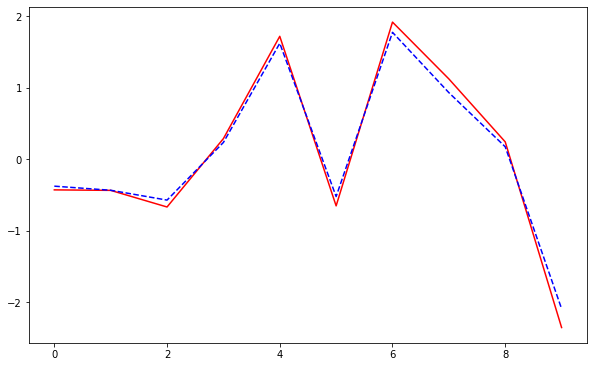

In [18]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(logistic_model.linear.bias.detach().numpy(), 'r')
ax.plot(W[:, -1], 'b--')

In [19]:
print('WEIGHT')
print('before training,', w_before_training)
print('after training,', w_after_training) 
print('initialisation : ', W[:, :-1].T)

WEIGHT
before training, Parameter containing:
tensor([[ 0.0050,  0.0304,  0.0451,  ...,  0.0532,  0.0584, -0.0037],
        [ 0.0609, -0.0096,  0.0226,  ...,  0.0115,  0.0483, -0.0312],
        [ 0.0381, -0.0097,  0.0008,  ..., -0.0462,  0.0091,  0.0139],
        ...,
        [-0.0466, -0.0419,  0.0164,  ..., -0.0133, -0.0123,  0.0306],
        [-0.0334, -0.0236,  0.0114,  ..., -0.0347,  0.0273, -0.0582],
        [ 0.0620, -0.0376,  0.0350,  ..., -0.0197,  0.0478,  0.0165]],
       requires_grad=True)
after training, Parameter containing:
tensor([[-2.0671, -0.2213, -0.8965,  ...,  0.3907,  0.2345, -0.8305],
        [-0.5362,  1.0771,  0.7996,  ...,  0.2057,  1.2393, -0.2975],
        [ 0.4562, -0.3175,  1.8979,  ...,  0.0213, -0.9105,  1.2354],
        ...,
        [-0.5974, -1.5241, -2.1185,  ..., -1.8945,  0.3709, -1.0723],
        [ 0.6723,  1.5560,  0.4269,  ..., -0.2341, -0.0978, -0.5893],
        [ 1.5167,  1.0203, -2.3404,  ...,  2.1179, -0.4622,  1.5999]],
       requires_grad=

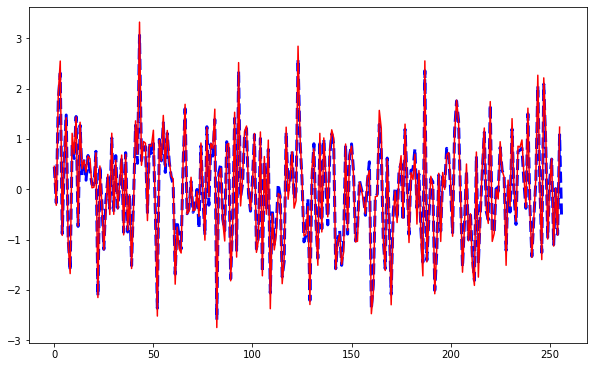

In [20]:
i_digit = 2
fig, ax = plt.subplots(figsize=figsize)
ax.plot(W[i_digit, :], 'b--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')

On voit que les biais et les poids ont changé après l'apprentissage pour se rapprocher de ceux de l'intialisation

## labels Poisson

The [Poisson distribution](https://numpy.org/devdocs/reference/random/generated/numpy.random.poisson.html) is the limit of the binomial distribution for large N.

In [21]:
X, p, y = get_data(W, seed=seed, N_batch=10000, X_type='poisson')
logistic_model, loss = fit_data(X, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.42044
Iteration: 16 - Loss: 0.12608
Iteration: 32 - Loss: 0.11009
Iteration: 48 - Loss: 0.10472
Iteration: 64 - Loss: 0.10288
Iteration: 80 - Loss: 0.10135
Iteration: 96 - Loss: 0.10021
Iteration: 112 - Loss: 0.09994
Iteration: 128 - Loss: 0.09950
Iteration: 144 - Loss: 0.09964
Iteration: 160 - Loss: 0.09906
Iteration: 176 - Loss: 0.09893
Iteration: 192 - Loss: 0.09883
Iteration: 208 - Loss: 0.09861
Iteration: 224 - Loss: 0.09832
Iteration: 240 - Loss: 0.09855
Iteration: 256 - Loss: 0.09870
Iteration: 272 - Loss: 0.09852
Iteration: 288 - Loss: 0.09830
Iteration: 304 - Loss: 0.09847
Iteration: 320 - Loss: 0.09816
Iteration: 336 - Loss: 0.09843
Iteration: 352 - Loss: 0.09847
Iteration: 368 - Loss: 0.09823
Iteration: 384 - Loss: 0.09817
Iteration: 400 - Loss: 0.09843
Iteration: 416 - Loss: 0.09842
Iteration: 432 - Loss: 0.09803
Iteration: 448 - Loss: 0.09807
Iteration: 464 - Loss: 0.09831
Iteration: 480 - Loss: 0.09800
Iteration: 496 - Loss: 0.09821
Iteration: 512 -

ça "marche" toujours: un label binaire permet toujours de superviser l'apprentissage:

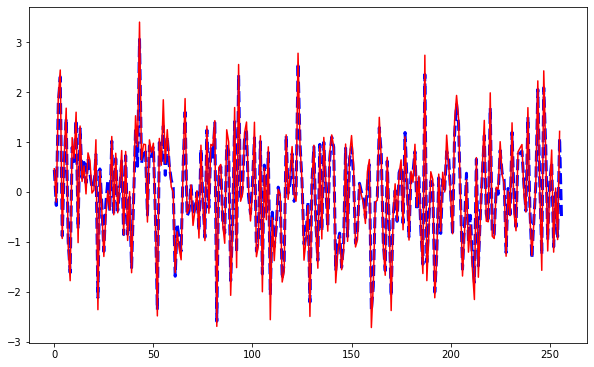

In [22]:
i_digit = 2
fig, ax = plt.subplots(figsize=figsize)
ax.plot(W[i_digit, :], 'b--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')

## labels binaires

In [23]:
X, p, y = get_data(W, seed=seed, N_batch=10000, X_type='binary')
logistic_model, loss = fit_data(X, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.41744
Iteration: 16 - Loss: 0.12496
Iteration: 32 - Loss: 0.10989
Iteration: 48 - Loss: 0.10491
Iteration: 64 - Loss: 0.10245
Iteration: 80 - Loss: 0.10092
Iteration: 96 - Loss: 0.10033
Iteration: 112 - Loss: 0.10005
Iteration: 128 - Loss: 0.09948
Iteration: 144 - Loss: 0.09948
Iteration: 160 - Loss: 0.09891
Iteration: 176 - Loss: 0.09880
Iteration: 192 - Loss: 0.09861
Iteration: 208 - Loss: 0.09874
Iteration: 224 - Loss: 0.09882
Iteration: 240 - Loss: 0.09874
Iteration: 256 - Loss: 0.09860
Iteration: 272 - Loss: 0.09843
Iteration: 288 - Loss: 0.09829
Iteration: 304 - Loss: 0.09866
Iteration: 320 - Loss: 0.09821
Iteration: 336 - Loss: 0.09889
Iteration: 352 - Loss: 0.09906
Iteration: 368 - Loss: 0.09849
Iteration: 384 - Loss: 0.09848
Iteration: 400 - Loss: 0.09841
Iteration: 416 - Loss: 0.09878
Iteration: 432 - Loss: 0.09823
Iteration: 448 - Loss: 0.09859
Iteration: 464 - Loss: 0.09844
Iteration: 480 - Loss: 0.09809
Iteration: 496 - Loss: 0.09838
Iteration: 512 -

ça "marche" toujours: un label binaire permet toujours de superviser l'apprentissage:

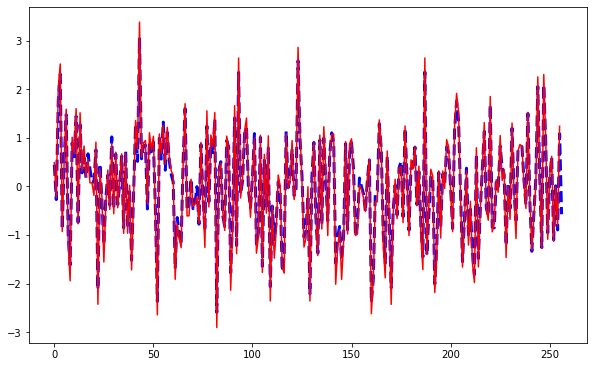

In [24]:
i_digit = 2
fig, ax = plt.subplots(figsize=figsize)
ax.plot(W[i_digit, :], 'b--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')

## un modele réaliste de courbes d'accord

Text(0.5, 0, 'address')

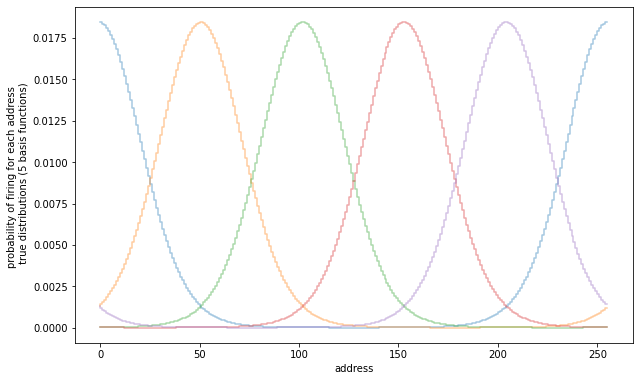

In [25]:

N_trials = 2**11 # number of trials
p1 = .01 # average firing probability
N = 2**8 # number of addresses
K = 5 # number of patterns
sigma = .51 # bandwidth

# a simple circular function to generate patterns
def von_mises(j, N, sigma):
    p = np.exp( np.cos(2*np.pi* (np.linspace(0, 1, N, endpoint=False) -j/N)) / sigma**2)
    p /= p.sum()
    return p

def stack(K, N, sigma):
    p = np.zeros((K, N))
    for k in range(K):
        p[k, :] = von_mises(k*N/K, N, sigma)
    return p

p_true = stack(K, N, sigma)

N_hyp = p_true.shape[0]
fig, ax = plt.subplots(1, 1, figsize=figsize)
for i_test in range(N_hyp):
    ax.step(np.arange(N), p_true[i_test, :], alpha=.4)
ax.set_ylabel('probability of firing for each address \n true distributions (5 basis functions)')
ax.set_xlabel('address')

In [26]:
W.shape, W.min(), W.max(), p_true.shape

((10, 257), -3.6586960825627957, 3.4414146081878902, (5, 256))

In [27]:
seed = 2402
N = 256 # nombre de valeurs de l'entrée
K = 10 # nombre de classes
N_batch = 10000 # nombre d'échantillons
seed = 1973

#np.random.seed(seed)
#W = np.random.randn(N+1, n_classes) # FIXED design matrix of weights (w) according to classes
p_true = stack(K, N, sigma)

In [28]:
p_true.shape

(10, 256)

In [29]:
p_true = np.hstack((p_true, 0.1*np.ones((K, 1))))

In [30]:
p_true.shape

(10, 257)

In [31]:
W = np.log(p_true/(1-p_true))

In [32]:
X, p, y = get_data(W, seed=seed, N_batch=N_batch)

In [33]:
X.shape, y.shape

((10000, 256), (10000, 10))

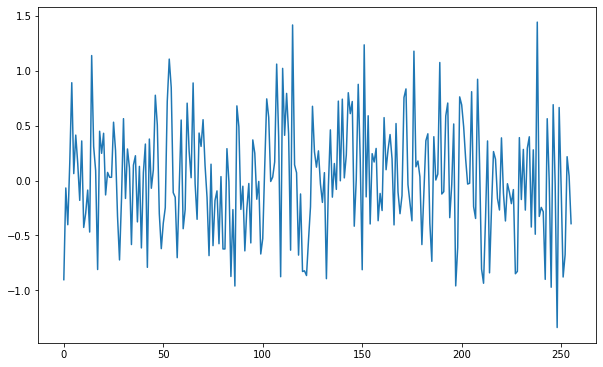

In [34]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot(np.arange(N), X[0, :])

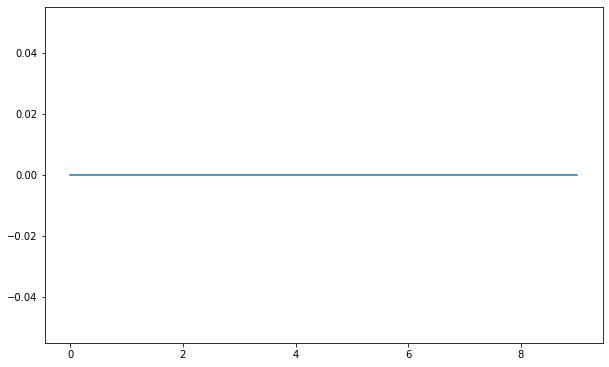

In [35]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot(np.arange(n_classes), y[0, :])

In [36]:
logistic_model, loss = fit_data(X, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.49125
Iteration: 16 - Loss: 0.09875
Iteration: 32 - Loss: 0.07346
Iteration: 48 - Loss: 0.06234
Iteration: 64 - Loss: 0.05572
Iteration: 80 - Loss: 0.05118
Iteration: 96 - Loss: 0.04779
Iteration: 112 - Loss: 0.04515
Iteration: 128 - Loss: 0.04299
Iteration: 144 - Loss: 0.04115
Iteration: 160 - Loss: 0.03960
Iteration: 176 - Loss: 0.03827
Iteration: 192 - Loss: 0.03709
Iteration: 208 - Loss: 0.03602
Iteration: 224 - Loss: 0.03506
Iteration: 240 - Loss: 0.03423
Iteration: 256 - Loss: 0.03342
Iteration: 272 - Loss: 0.03270
Iteration: 288 - Loss: 0.03204
Iteration: 304 - Loss: 0.03144
Iteration: 320 - Loss: 0.03084
Iteration: 336 - Loss: 0.03031
Iteration: 352 - Loss: 0.02981
Iteration: 368 - Loss: 0.02936
Iteration: 384 - Loss: 0.02891
Iteration: 400 - Loss: 0.02847
Iteration: 416 - Loss: 0.02810
Iteration: 432 - Loss: 0.02772
Iteration: 448 - Loss: 0.02737
Iteration: 464 - Loss: 0.02703
Iteration: 480 - Loss: 0.02670
Iteration: 496 - Loss: 0.02638
Iteration: 512 -

Text(0.5, 0, 'address')

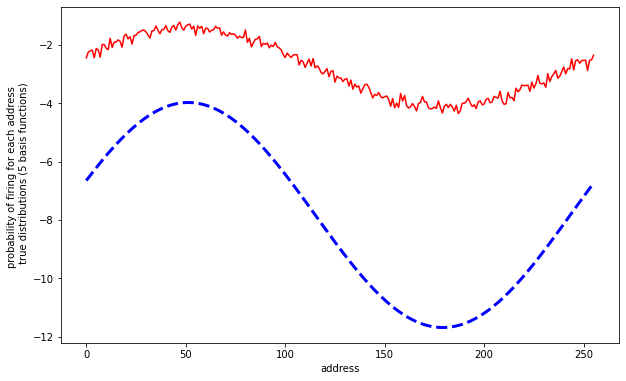

In [37]:
i_digit = 2
fig, ax = plt.subplots(figsize=figsize)
ax.plot(W[i_digit, :-1], 'b--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')
ax.set_ylabel('probability of firing for each address \n true distributions (5 basis functions)')
ax.set_xlabel('address')

Text(0.5, 0, 'address')

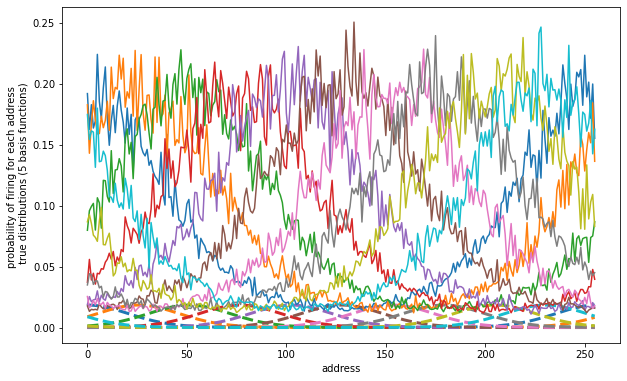

In [38]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(sigmoid(W[:, :-1]).T, '--', lw=3)
ax.plot(sigmoid(logistic_model.linear.weight[:, :].detach().numpy()).T, '-')
ax.set_ylabel('probability of firing for each address \n true distributions (5 basis functions)')
ax.set_xlabel('address')

Text(0.5, 0, 'address')

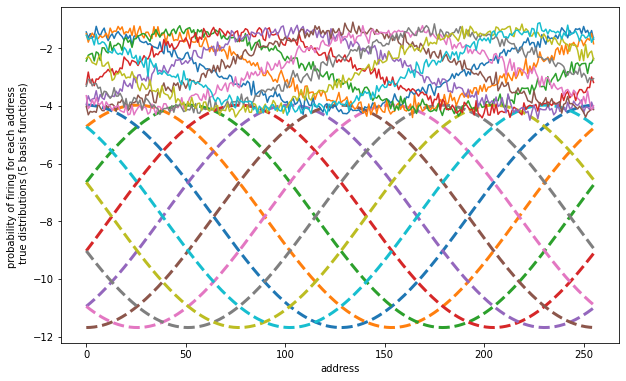

In [39]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(W[:, :-1].T, '--', lw=3)
ax.plot(logistic_model.linear.weight[:, :].detach().numpy().T, '-')
ax.set_ylabel('probability of firing for each address \n true distributions (5 basis functions)')
ax.set_xlabel('address')